# Проверка гипотез по увеличению выручки в интернет-магазине - оценка результатов A/B теста

**Описание проекта**

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки. В нашем распоряжении есть файлы с данными о гипотезах, заказах пользователей и результатами A/B-теста.

**Задача проекта**

Используя данные интернет-магазина приоритезировать гипотезы, произвести оценку результатов A/B-тестирования различными методами.

**Описание данных**

Файл /datasets/hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

Файл /datasets/orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

**План работы:**

- Загрузить данные и подготовить их к анализу
- Приоритизировать гипотезы с применением фреймворков ICE и RICE
- Провести анализ A/B-теста
- Принять решение по результатам A/B-теста 
- Сформулировать общий вывод

## Подготовка данных

### Загрузка данных

In [1]:
#импорт библиотек:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
import time
import datetime as dt
from datetime import datetime
from datetime import date, timedelta as td
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка данных:
hypothesis = pd.read_csv('C:/Users/OT/Desktop/проекты/Выручка им/hypothesis.csv', sep=',')
orders = pd.read_csv('C:/Users/OT/Desktop/проекты/Выручка им/orders.csv', sep=',') 
visitors = pd.read_csv('C:/Users/OT/Desktop/проекты/Выручка им/visitors.csv', sep=',')

print('hypothesis')
display(hypothesis)
print('---------------------------------')
print('orders')
display(orders.head())
print('---------------------------------')
print('visitors')
display(visitors.head())

hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


---------------------------------
orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


---------------------------------
visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Предобработка файлов orders и visitors

Проверим файлы orders и visitors на наличие дубликатов, пропусков и соответствие типам данных:

In [3]:
#проверяем orders:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [4]:
print('Количество дубликатов:',orders.duplicated().sum())

Количество дубликатов: 0


In [5]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [6]:
#изменим тип данных в столбце date:
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


Начальная дата 2019-08-01, конечная дата 2019-08-31



In [7]:
#проверка:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
#проверяем visitors:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
print('Количество дубликатов:',visitors.duplicated().sum())

Количество дубликатов: 0


In [10]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [11]:
#изменим тип данных в столбце date:
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


Начальная дата 2019-08-01, конечная дата 2019-08-31



In [12]:
#проверка:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Проверка корректности разбиения на группы

Проверим корректность разбиения пользователей на группы (могут быть пользователи, попавшие в обе группы):

In [13]:
#находим "двойных" пользователей
duplicated_users = orders.groupby('visitorId').agg({'group' : ['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_names'] 
duplicated_users = duplicated_users.query('groups > 1')
print('Количество "двойных" пользователей:', len(duplicated_users))

Количество "двойных" пользователей: 58


In [14]:
#находим число всех пользователей
orders['visitorId'].nunique()

1031

In [15]:
#считаем долю "двойных" пользователей от общего количества покупателей
print('Доля "двойных" пользователей: {:.2%}'.format(58 / orders['visitorId'].nunique()))

Доля "двойных" пользователей: 5.63%


Итак, у нас есть больше 5% пользователей, попавших в обе группы. При удалении их из таблицы orders надо также очистить таблицу visitors, но в ней нет данных о visitorId. Поэтому не получится корректно провести удаление "двойных" пользователей. Оставляем их в данных.

### Вывод

Данные загружены. Пропусков и дубликатов нет. Тип данных у столбцов с датами изменен с object на datetime64. Начальная и конечная даты в таблицах orders и visitors совпадают.

## Приоритизация гипотез

### Как рассчитываются гипотезы

Для оценки и приоритизации гипотез применяются 4 параметра:
- Reach — охват (скольких пользователей затронет изменение, которое хотят внести);
- Impact — влияние (как изменение повлияет на пользователей, их опыт и удовлетворение от продукта);
- Confidence — уверенность в оценках (насколько вы уверены, что это изменение повлияет на пользователей именно так);
- Efforts — усилия (трудозатраты, необходимые на тестирование гипотезы).

Эти параметры фреймворков оценивают в удобных шкалах: например, от 0 до 10. Высший приоритет получает гипотеза с наибольшим охватом и влиянием при минимальных усилиях.

### Приоритизация методом ICE

Применим фреймворк ICE для приоритизации гипотез. Отсорируем гипотезы по убыванию приоритета.

In [16]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis_ICE = hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
hypothesis_ICE

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы 8, 0 и 7.

### Приоритизация методом RICE

Теперь применим фреймворк RICE для приоритизации гипотез. Отсорируем гипотезы по убыванию приоритета.

In [17]:
#настроим функцию display для полного отображения названия гипотез
pd.options.display.max_colwidth = 400

In [18]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact']*hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis_RICE = hypothesis[['Hypothesis', 'RICE']]. sort_values(by='RICE',ascending=False)
hypothesis_RICE

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы 7, 2 и 0. Гипотеза 7 имеет наивысший приоритет. Гипотеза 0 опустилась со второго на третье место. Гипотеза 2 заняла второе место.

Сравним приоритизацию гипотез при применении ICE и RICE:

In [19]:
priority_of_hypothesis = hypothesis_ICE.merge(hypothesis_RICE, on='Hypothesis')
display(priority_of_hypothesis)

,Hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


Изменение приоритетности объясняется тем, что в методе RICE используется параметр охвата изменений Reach. Гипотеза 7 имеет наибольший Reach = 10, поэтому она получила высший приоритет.

### Вывод

- По методу ICE наиболее перспективные гипотезы 8, 0 и 7, по методу RICE - 7, 2 и 0.
- Различия в приоритете гипотез обусловлены использованием параметра охвата Reach.
- Наиболее приоритетные гипотезы 7, 2, 0.

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


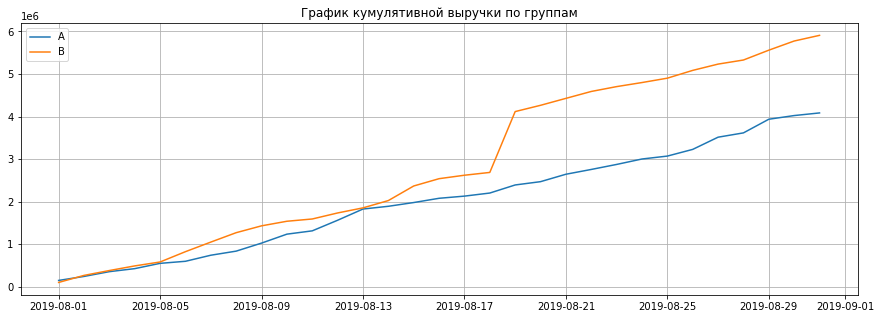

In [21]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.grid()
plt.legend()
plt.title('График кумулятивной выручки по группам');

Выручка почти равномерно увеличивается в течение всего теста. В первой половине месяца видно, что выручка в группе B растёт чуть быстрее, чем в A. 13 августа выручки сравнялись. Во второй половине месяца выручка группы B становится значительно больше. 19 августа наблюдается скачок выручки в группе B. Это может сигнализировать о всплесках числа заказов, либо о размещении очень дорогих заказов в этот день.

### График кумулятивного среднего чека по группам

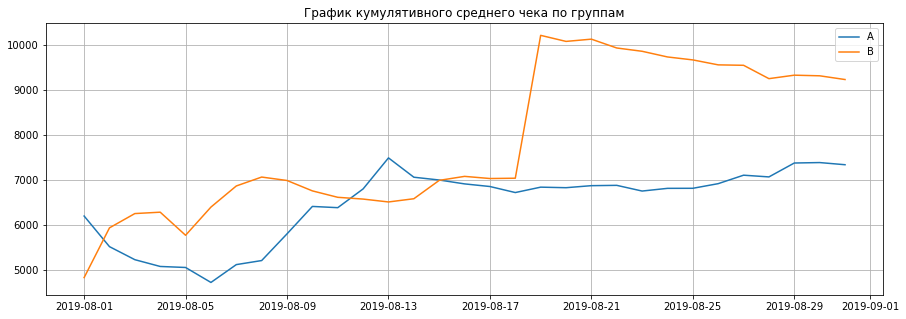

In [22]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.title('График кумулятивного среднего чека по группам');

Средний чек также растет  на протяжении теста. В группе A он достигает пика 13 августа, затем несколько снижается, а к концу месяца выходит примерно на уровень 13 августа. В группе В видим резкий скачок 19 августа (вероятно, обусловленный крупным заказом), затем средний чек в B постепенно снижается. В целом средний чек в группе В больше. 

### График относительного изменения кумулятивного среднего чека группы В к группе А

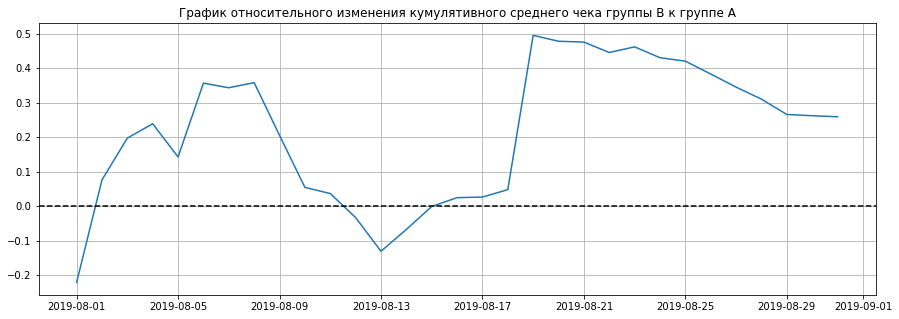

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.grid()

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А');

Средний чек B уже 2 августа превысил A и рос до 7 августа. 8 августа начался спад до 13 августа, причем 3 дня 12-14 августа средний чек A был больше B. 16 августа  средний чек B оказался больше А и был больше до конца месяца. Здесь так же виден рост  19 августа с последующим постепенным снижением. 

### График кумулятивной конверсии по группам

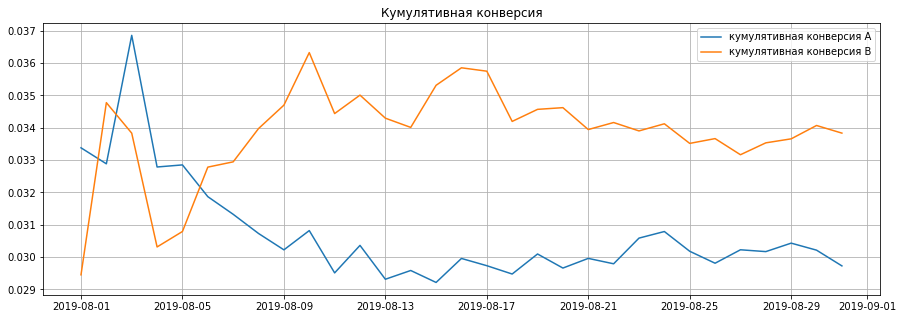

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='кумулятивная конверсия A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='кумулятивная конверсия B')
plt.title('Кумулятивная конверсия')
plt.legend();
# plt.axis(["2019-08-01", '2019-08-31', 0.028, 0.038]) ;

С начала месяца конверсия A была значительно больше B, после пика 3 августа она начала сильно падать и начиная с 9 августа стагнировала  в  диапазоне 0,029-0,031. Конверсия группы B начала расти с 4 августа, 6 августа превысила конверсию A и росла до 10 августа чуть выше 0,036, затем начала постепенно снижаться. В целом конверсия группы B значительно больше А.

### График относительного изменения кумулятивной конверсии группы В к группе А

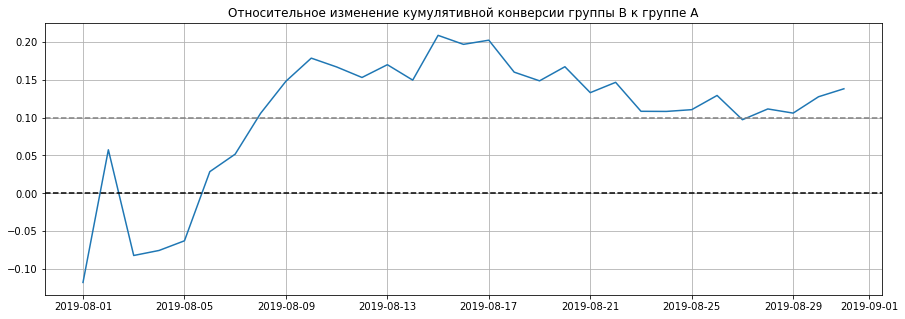

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
                                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')

plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.1, color='grey', linestyle='--');

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Начиная с 6 августа группа B лидировала до конца периода; её конверсия росла до 15 августа, затем пошло постепенное снижение. В конце месяца наблюдается рост. 

### Точечный график количества заказов по пользователям

In [26]:
#сортируем заказы по пользователям
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['user_id','orders']
ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


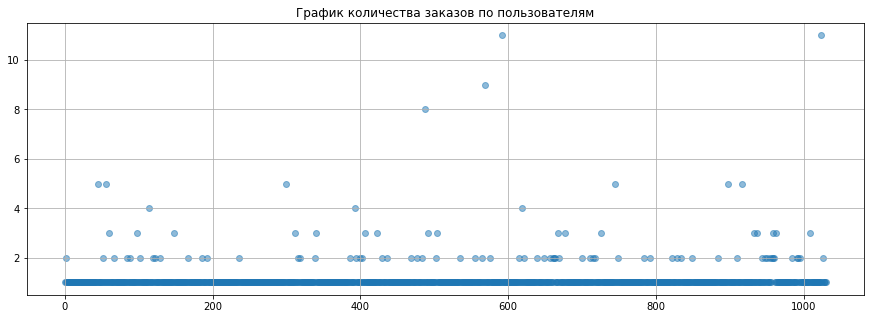

In [27]:
#строим график
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5);

Большинство пользователей делают 1 заказ. Есть пользователи, которые делают 2 заказа, но их значительно меньше. Еще меньше пользователей делают 3 заказа. Выше 4 заказов - явно аномалия. Точно определить выбросы можно после расчета перцентилей. 

### Определение аномальных пользователей

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя:

In [28]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Меньше 1% пользователей сделали больше 4 заказов, меньше 5% пользователей сделали больше 2 заказов.

Выберем  4 заказа на одного пользователя за нижнюю границу числа заказов.

### Точечный график стоимости заказов

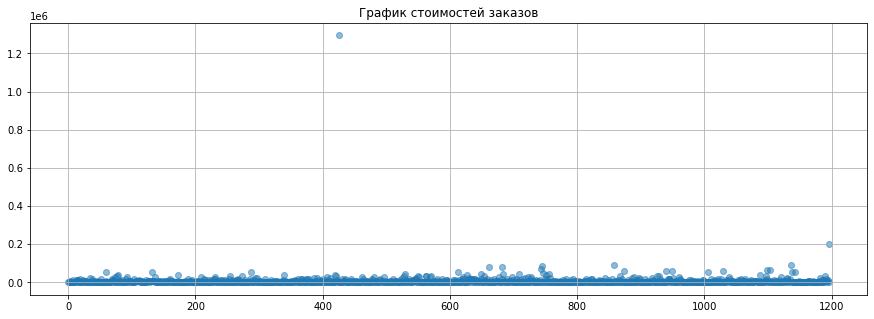

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.5);

Видим огромный выброс на одного пользователя со стоимостью заказа более 1.2 млн. Для наглядности построим график с ограничем по У-оси.

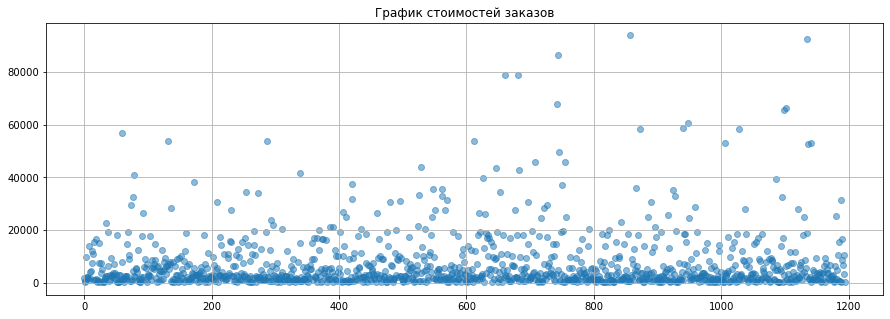

In [30]:
norm_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(norm_orders)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.scatter(xn_values, norm_orders, alpha=0.5);

По графику можно выбрать границу аномальных заказов между 20 000 и 40 000 рублей. Точнее определит расчет перцентилей.

### Определение аномальных заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов:

In [31]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


99% заказов меньше суммы 58233.2 , установим её в качестве границы для аномалий.

### Расчет статистической значимости различий в конверсии между группами по "сырым" данным

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:

Нулевая гипотеза: различий в конверсии между группами А и В нет.

Альтернативная гипотеза: различия в конверсии между группами А и В есть.

Подготовим данные: создадим несколько таблиц и объединим их:

In [32]:
#cобираем таблицы с данными о пользователях
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#собираем таблицы с данными о заказах
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#объединяем в одну таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Для расчета статистической значимости различия в конверсии между группами создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [34]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим непараметрический критерий Манна-Уитни, так как он подходит для нашего случая, когда в данных есть выбросы.

In [35]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

alpha = 0.05
p-value = 0.017
Относительный показатель 'B' и 'A' = 0.138


p-value = 0.017 меньше 0.05. Значит, отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет. То есть по «сырым» данным различия в конверсии групп A и B есть. Относительный выигрыш группы B над A равен 13.8% .

### Расчет статистической значимости различий в среднем чеке заказа между группами по "сырым" данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

Для расчета статистической значимости различий в среднем чеке передадим критерию mannwhitneyu() данные о выручке с заказов и
найдём относительные различия в среднем чеке между группами:

In [36]:
print("alpha =",0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha = 0.05
p-value = 0.729
Относительный показатель 'B' и 'A' = 0.259


По "сырым", не очищенным от выбросов данным наблюдаем различие: cредний чек группы B значительно выше среднего чека группы A (на ~26%). Но p-value = 0.729 больше 0.05, т.к. тест Манна-Уитни не чувствителен к выбросам и все равно показывает, что различий нет. Значит, нет причин отвергать нулевую гипотезу. По «сырым» данным средние чеки групп А и В схожи. 

### Расчет статистической значимости различий в конверсии между группами по "очищенным" данным

В предыдущих пунктах мы приняли за аномальных пользователей тех, кто совершил больше 4 заказов или заказ дороже 58233.2 рублей. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 58233.2  — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. Узнаем, сколько всего аномальных пользователей методом shape().

In [37]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId'],
    ],
    axis=0,
)
revenue_lim = np.percentile(orders['revenue'], 99)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitorId, dtype: int64
(15,)


Всего 15 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [38]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть. Применим статистический критерий Манна-Уитни к полученным выборкам.

In [39]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.014
Относительный показатель 'B' и 'A' = 0.153


p-value = 0.014 меньше 0.05. Значит, отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет. То есть и по "очищенным" данным различия в конверсии групп A и B есть. Относительный выигрыш группы B над A равен 15,3% (этот на 1,5% выше, чем по «сырым» данным).

### Расчет статистической значимости различий в среднем чеке заказа между группами по "очищенным" данным

Посмотрим теперь результаты по среднему чеку. Нулевая и альтернативная гипотезы те же.

In [40]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print("Относительный показатель 'B' и 'A' = {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.851
Относительный показатель 'B' и 'A' = -0.006


p-value больше 0.05, т.е. нет причин отвергать нулевую гипотезу. Имеется статистически незначимое различие: средний чек группы B чуть ниже среднего чека группы A (на 0,6%). По "сырым" данным он был больше на 13,8%. Причина в выбросе - заказе на 1,29 млн, который мы удалили из выборки. Можем заключить, что по «очищенным» данным средние чеки схожи (как и по "сырым" данным). 

### Принятие решения по результатам теста

По результатам теста было выявлено:
- имеются статистические различия между конверсией группы А и конверсией группы В как по "сырым", так и по "очищенным" данным; 
- относительный выигрыш группы B над А по конверсии равен 15,3% по "очищенным" и 13.8% по "сырым" данным;
- статистические различия в среднем чеке между группами А и В отсутствуют как по "сырым", так и по "очищенным" данным;
- средний чек группы B был больше по "сырым" данным на ~26%, а по "очищенным" оказался незначительно (на 0,6%) ниже среднего чека группы A. Причина - аномальный заказ на 1,29 млн.

Можно принять решение остановить тест и зафиксировать победу группы В: она значительно лучше по конверсии, хотя по среднему чеку группы примерно равны.

## Вывод

- Данные были загружены и подготовлены к анализу.
- Были определены наиболее приоритетные гипотезы: 7, 2, 0.
- Группа B лучше группы А по конверсии. По среднем чеку нет больших различий.
- Можно остановить A/B-тест и зафиксировать победу группы В.